In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

plt.style.use("seaborn-darkgrid")
dl = DataLib("SignalData")

In [2]:
# Pull necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
rGDP = dl.pull("GDP/Real")
sr = dl.pull("ShortRates")

In [32]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

In [43]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Overview

In this notebook, we try and get some intuition for why GDP might be a driver of bond returns. We also try to construct and indicator which captures changes in GDP relative to a recent average. 

`TODO`
- Potentially resample from quarterly to monthly to generate a monthly indicator?

# Relationship between GDP and Short Rates

What would we expect here? As GDP growth continues, central banks tighten the economy, forcing rates up. So we might expect changes in short rates to follow changes in GDP, perhaps with some lag. 

The aforementioned relationship does appear. Short rates follow (roughly) the ups and downs of GDP, with a little lag. 

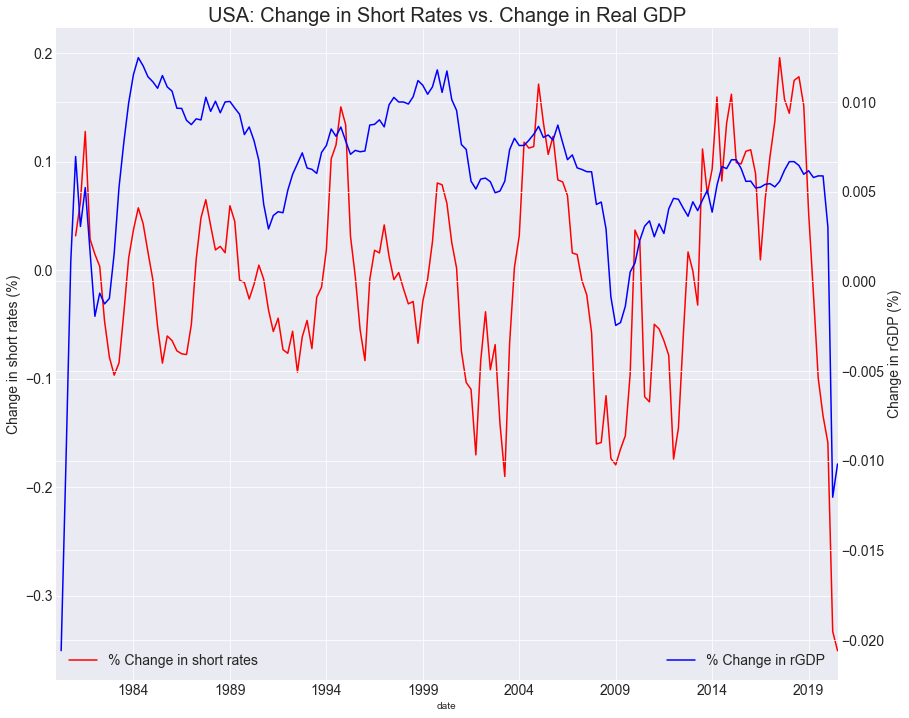

pearson correlation: 0.454516506231149


<AxesSubplot:title={'center':'correlation by country'}, xlabel='country'>

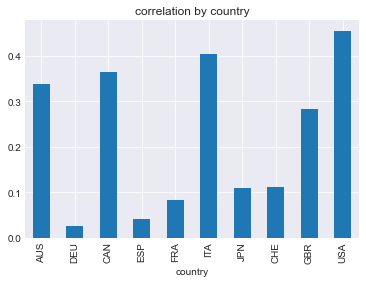

In [24]:
# Get change in short rates (indexed by month - change to quarters), and take a rolling average.
sr_chg = sr.resample('Q').mean().pct_change()
sr_chg_sma = sr_chg.rolling(4).mean() # 1 year rolling average. 

# Get change in rGDP, and take a rolling average. 
rGDP_chg = rGDP.pct_change()
rGDP_chg_ewm = rGDP_chg.ewm(span=12).mean()

# Plot change in short rates and change in GDP. 
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_ylabel("Change in short rates (%)", fontsize=14)
sr_chg_sma['USA'].plot(color='red', label='% Change in short rates', fontsize=14)
plt.legend(loc=3, prop={'size': 14})
axtwin = ax.twinx()
axtwin.set_ylabel("Change in rGDP (%)", fontsize=14)
ax = rGDP_chg_ewm['USA'].plot(ax=axtwin, color='blue', label='% Change in rGDP', fontsize=14, title="USA: Change in Short Rates vs. Change in Real GDP")
plt.legend(loc=4, prop={'size': 14})
ax.title.set_size(20)
plt.show()

print('pearson correlation:', sr_chg_sma['USA'].corr(rGDP_chg_ewm['USA']))

sr_chg_sma.corrwith(rGDP_chg_ewm).plot.bar(title='correlation by country')

Let's try manipulate the lag and see if we can get better correlation. Let's do this by moving GDP forward a few quarters. 3 quarters works pretty well. 

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

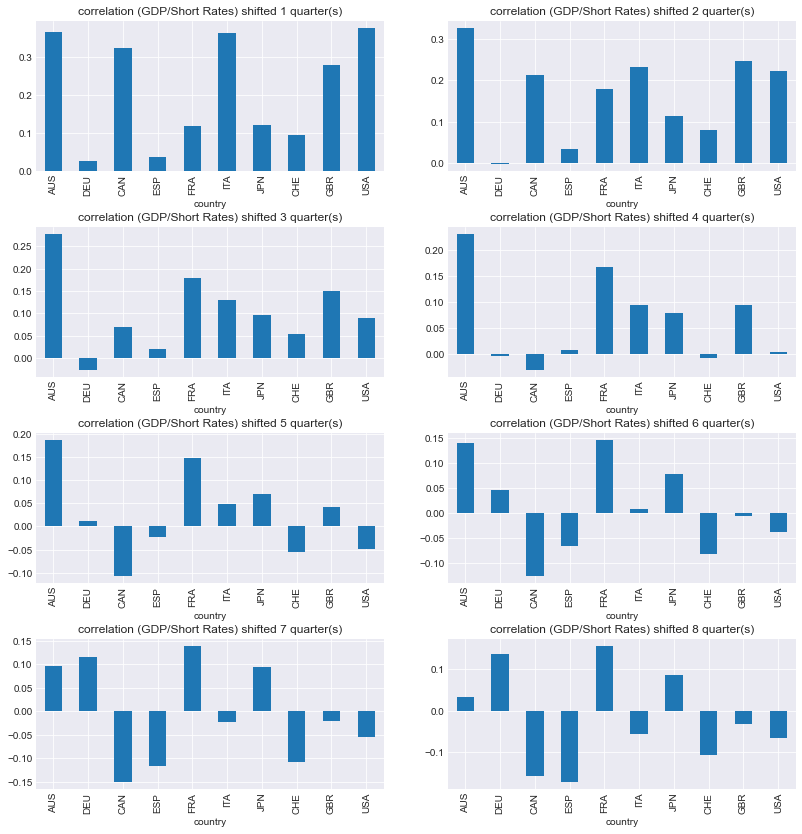

In [4]:
rGDP_chg_ewm_shifted = rGDP_chg_ewm

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    rGDP_chg_ewm_shifted = rGDP_chg_ewm.shift(shift)
    sr_chg_sma.corrwith(rGDP_chg_ewm_shifted).plot.bar(ax=ax, title='correlation (GDP/Short Rates) shifted {} quarter(s)'.format(shift))

# Relationship between GDP and Bond Returns

What would we expect here? As above, changes in short rates follow changes in GDP. Changes in rates are inversely related to bond returns, so we might expect change in GDP and change in bond returns to be opposites (i.e. reflections of one another). 

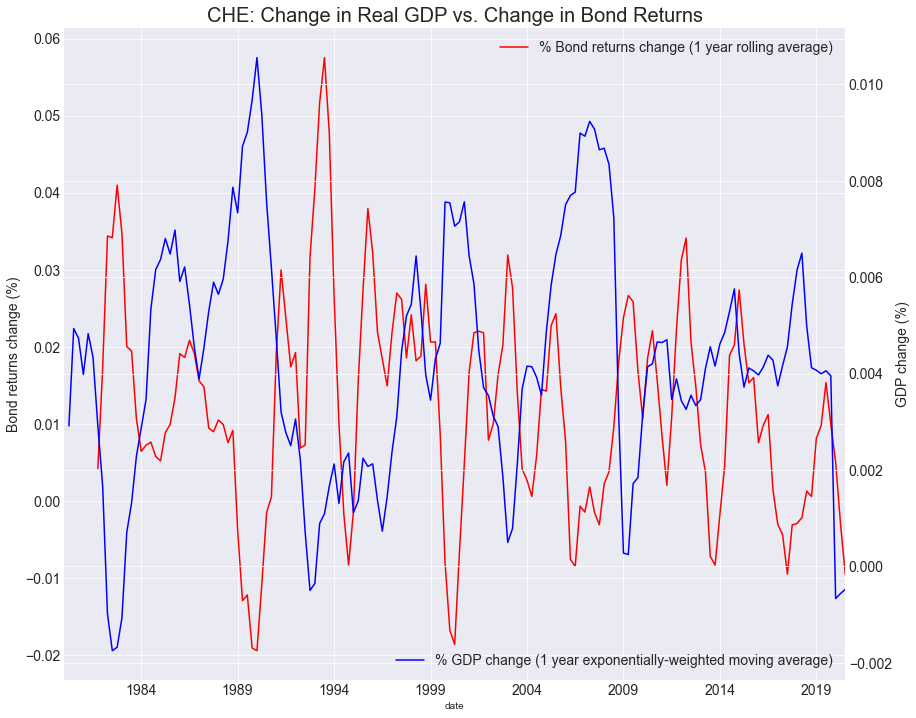

pearson correlation: -0.5769082529796935


<AxesSubplot:title={'center':'correlation between change in bond returns and change in GDP'}, xlabel='country'>

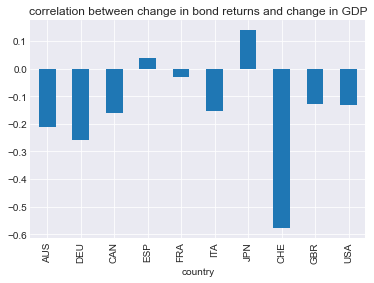

In [26]:
# Get the change q-on-q of bond returns. 
bri_chg = bri.resample('Q').mean().pct_change()
bri_chg_sma = bri_chg.rolling(4).mean() # 1-year rolling average. 

# Plot change in bond returns and change in GDP. 
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_ylabel("Bond returns change (%)", fontsize=14)
bri_chg_sma['CHE'].plot(color='red', label='% Bond returns change (1 year rolling average)', fontsize=14)
plt.legend(loc=1, prop={'size': 14})
axtwin = ax.twinx()
axtwin.set_ylabel("GDP change (%)", fontsize=14)
ax = rGDP_chg_ewm['CHE'].plot(ax=axtwin, color='blue', label='% GDP change (1 year exponentially-weighted moving average)', title="CHE: Change in Real GDP vs. Change in Bond Returns", fontsize=14)
ax.title.set_size(20)
plt.legend(loc=4, prop={'size': 14})
plt.show()

print('pearson correlation:', bri_chg_sma['CHE'].corr(rGDP_chg_ewm['CHE']))

bri_chg_sma.corrwith(rGDP_chg_ewm).plot.bar(title='correlation between change in bond returns and change in GDP')

This inverse relationship is somewhat apparent. The spike in GDP change in 2005 corresponds to a big dip in bond prices in 2006. Various other instances are visible, although with some exceptions. Let's see if introducing a lag has the same effect (improving correlation). Again, 3 months works relatively well (in terms of uniformity - most countries have negative correlation). 

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

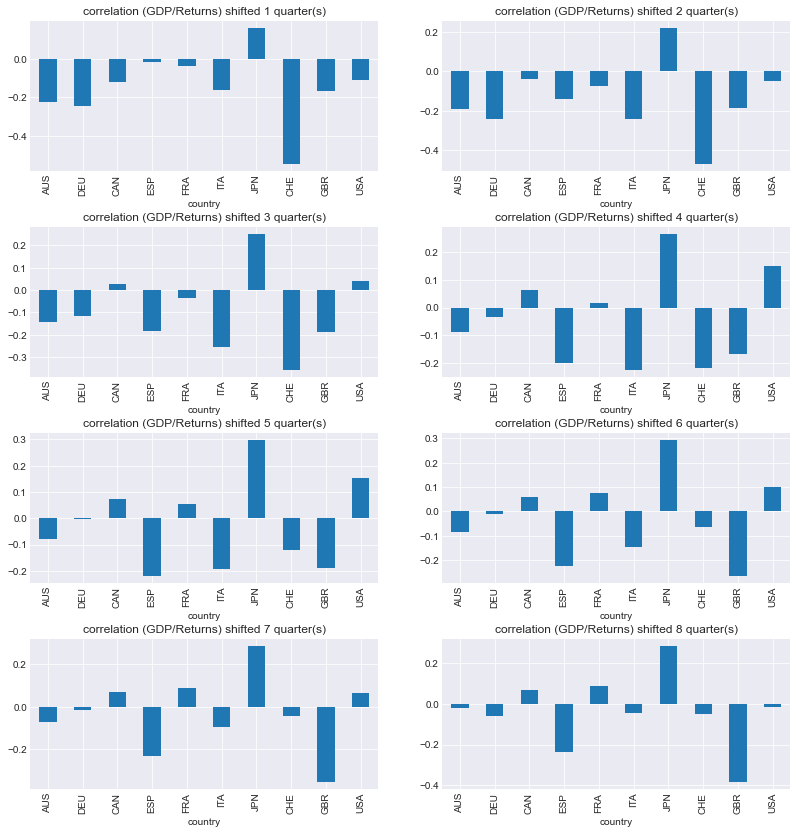

In [9]:
rGDP_chg_ewm_shifted = rGDP_chg_ewm

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    rGDP_chg_ewm_shifted = rGDP_chg_ewm.shift(shift)
    bri_chg_sma.corrwith(rGDP_chg_ewm_shifted).plot.bar(ax=ax, title='correlation (GDP/Returns) shifted {} quarter(s)'.format(shift))

# Build the indicator

Let's use a difference between the 6 month moving average the 18 month moving average (this oscillator captures local changes better than just a singular moving average). This also creates a much less volatile time series which is likely more useful. 

In [15]:
# Get the percentage change period-to-period. 
rGDP_chg = rGDP.pct_change()

# Get the mean across all countries of the 12-month rolling average of monthly change.
rGDP_chg_average = rGDP_chg.rolling(4).mean().mean(axis=1)

# Subtract this mean from the monthly change.
rGDP_chg_subglobal = rGDP_chg.subtract(rGDP_chg_average, axis=0)

# Turn the change into a zscore. 
sma = rGDP_chg_subglobal.rolling(4).mean()
std = rGDP_chg_subglobal.rolling(4).std()
zscore = (sma - rGDP_chg_subglobal) / std

In [16]:
# Save our indicator. 
dl.write_data("GDP_zscore", zscore)

Let's explore the relationship between this zscore and bond returns. 

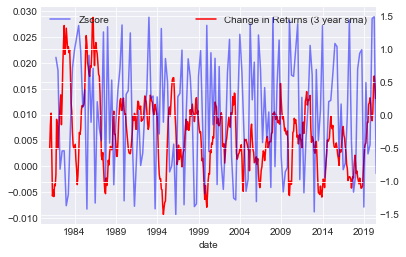

In [17]:
# Get percentage change period-to-period. 
bri_monthly = bri.resample('M').mean()
bri_chg = bri_monthly.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bri_chg['USA'].rolling(12).mean().plot(ax=ax1, color='red', label='Change in Returns (3 year sma)')
zscore['USA'].plot(ax=ax2, color='blue', alpha=0.5, label="Zscore")
ax1.legend()
ax2.legend(loc=2)

# Plot a restricted date window.
# bri_q_chg.loc['2000-01-01':'2005-01-01']['USA'].plot(ax=ax1, color='red')
# zscore.loc['2000-01-01':'2005-01-01']['USA'].plot(ax=ax2, color='blue')

Let's look at the relationship between our indicator and interest rates. 

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

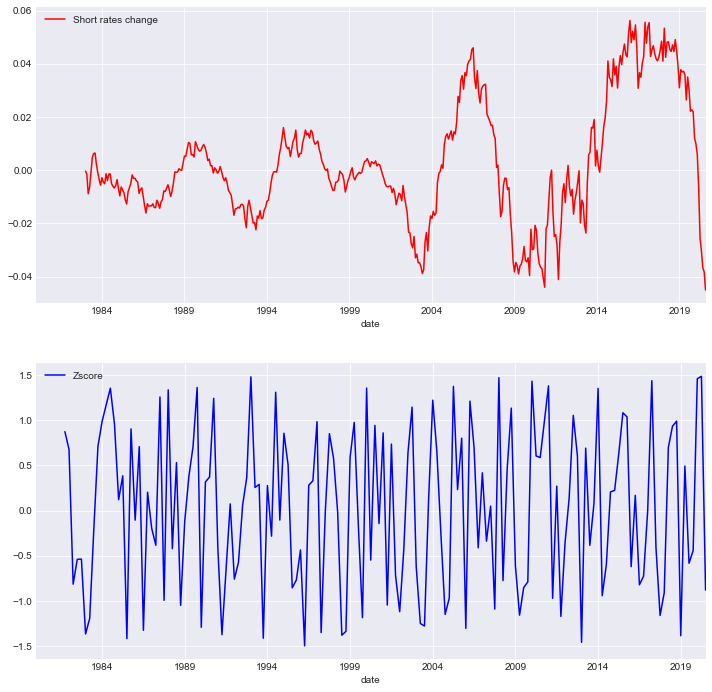

In [18]:
# Get change in short rates. 
sr_chg = sr.pct_change()
sr_chg_sma = sr_chg.rolling(36).mean()

# Plot change in short rates and our zscore. 
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

sr_chg_sma['USA'].plot(ax=axs[0], color='red', label='Short rates change')
axs[0].legend()
zscore['USA'].plot(ax=axs[1], color='blue', label="Zscore")
axs[1].legend()

# Return stream

As it stands, this indicator is pretty abysmal at generating returns. Need to refine how the indicator is constructed. 

In [19]:
# Convert the z-score to a signal by inverting it, then capping. 
# If this were multiple zscores, i'd take a weighted sum, then clip
signal = zscore.clip(upper=1.5, lower=-1.5) / 1.5
signal = signal[signal.index < '2020-01-01']
signal = signal.resample('B').ffill()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/oliverschwartz/.local/share/virtualenvs/Intership2020-KRb_1UV-/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

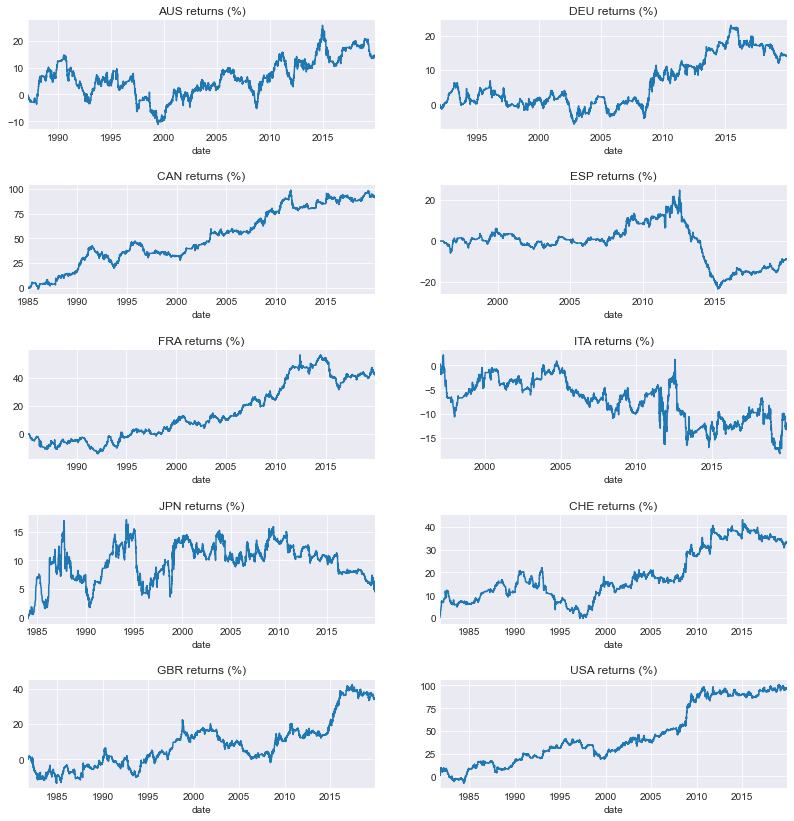

In [20]:
# Calculate cumulative returns. 
# bri_chg = bri.resample('M').mean().pct_change()
bri_chg = bri.pct_change()
returns = bri_chg.loc[signal.index].shift(-1)
returns = (signal * returns)       

# Plot the return stream for every country. 
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, country in enumerate(bri.columns.values):
    ax = axs[i//2][i%2]

    cumul_returns = ((returns[country].dropna() + 1).cumprod() - 1) * 100
    cumul_returns.plot(ax=ax, title='{} returns (%)'.format(country))

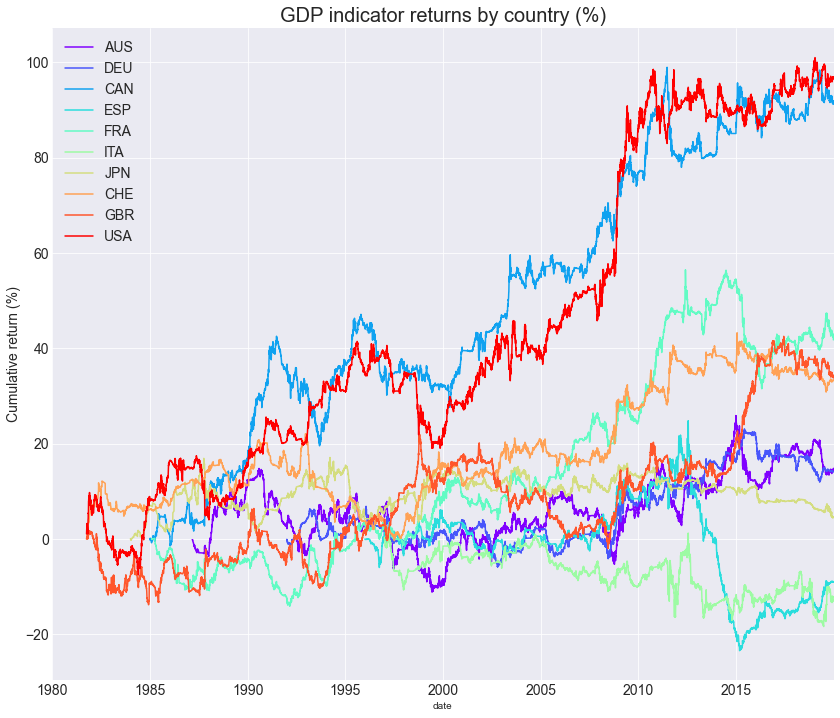

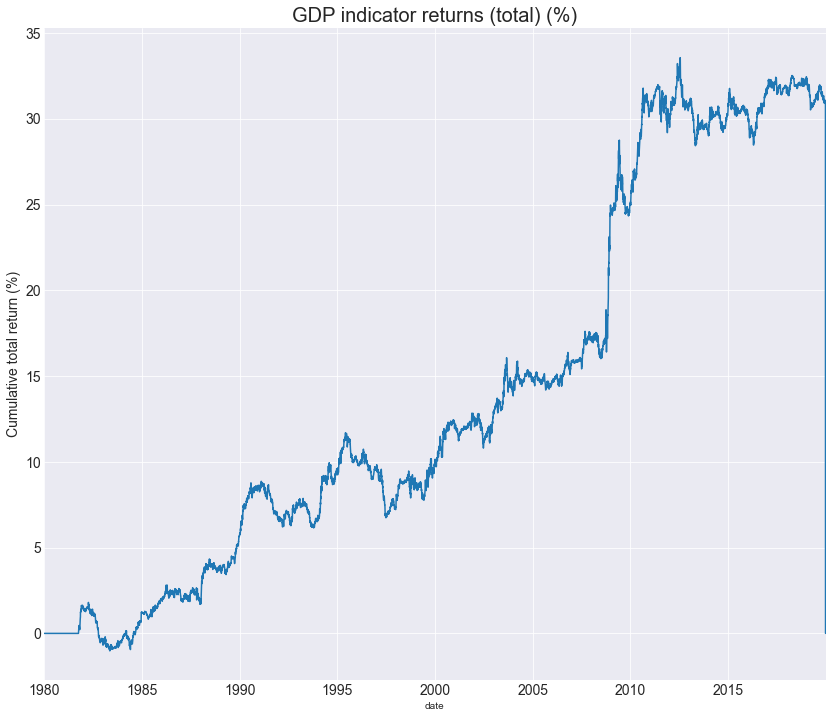

In [53]:
colors = pl.cm.jet(np.linspace(0,0.8,10))

# Plot all on same axis.
cumul_returns = ((returns + 1).cumprod() - 1) * 100
ax = cumul_returns.plot(title="GDP indicator returns by country (%)", figsize=(14,12), fontsize=14, cmap='rainbow')
ax.set_ylabel("Cumulative return (%)", fontsize=14)
ax.title.set_size(20)
plt.legend(prop={'size': 14})
plt.show()

# Plot the sum. 
ax = (cumul_returns * 0.1).sum(axis=1).plot(title="GDP indicator returns (total) (%)", figsize=(14, 12), fontsize=14)
ax.set_ylabel("Cumulative total return (%)", fontsize=14)
ax.title.set_size(20)